In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from phase_scan import PhaseScan
from inversion import Inversion

In [3]:
decimation_data = pd.read_csv("Decimation.csv")
pti_data = pd.read_csv("PTI_Inversion.csv")

# DC Values

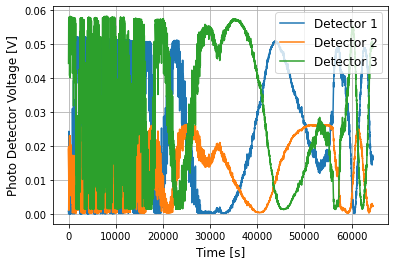

<Figure size 432x288 with 0 Axes>

In [4]:
time = np.arange(len(decimation_data["DC1"]))
for channel in range(1, 4):
    plt.plot(time, decimation_data[f"DC{channel}"], label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("Photo Detector Voltage [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.show()
plt.savefig("DC.pdf")

# RMS Values

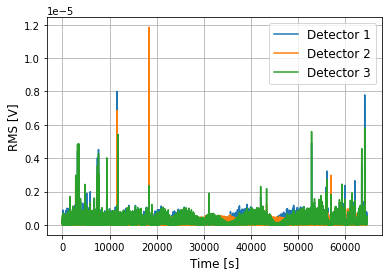

In [5]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.sqrt(decimation_data[f"X{channel}"] ** 2 + decimation_data[f"Y{channel}"] ** 2), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# Response Phases

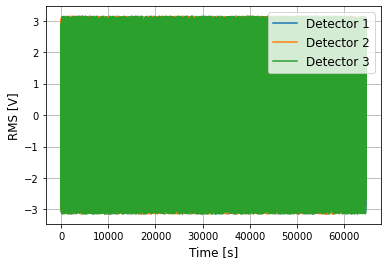

In [6]:
time = np.arange(len(decimation_data["X1"]))
for channel in range(1, 4):
    plt.plot(time, np.arctan2(decimation_data[f"Y{channel}"], decimation_data[f"X{channel}"]), label=f"Detector {channel}")
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("RMS [V]", fontsize=12)
plt.grid()
plt.legend(fontsize=12)
plt.savefig("RMS.pdf")

# PTI Signal

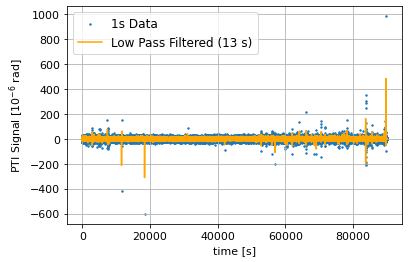

In [7]:
time = np.arange(len(pti_data["PTI Signal"]))
pti_mean = np.mean(np.array(pti_data["PTI Signal"]).reshape(-1, 2), axis=1)
time_mean = np.arange(pti_mean.size)
time_mean *= 2
fig, ax = plt.subplots()
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, -pti_data["PTI Signal"] * 1e6, s=2, label="1s Data")
plt.plot(time_mean, -pti_mean * 1e6, label="Low Pass Filtered (13 s)", color="orange")
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.legend(fontsize=12)
plt.ylabel("PTI Signal [$10^{-6}$ rad]", fontsize=11)
plt.savefig("pti.pdf", dpi=400, bbox_inches="tight")

# Interferometric Phase

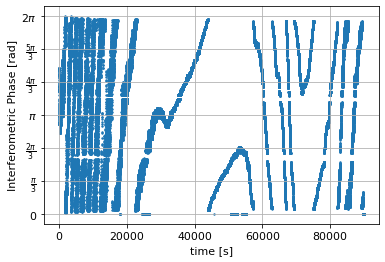

In [8]:
phases = pti_data["Interferometric Phase"].to_numpy()
phases[np.where(phases < 0)] += 2 * np.pi
_, ax = plt.subplots()
plt.yticks([0, np.pi / 3, 2 / 3 * np.pi, np.pi, 4 * np.pi / 3, 5 * np.pi / 3, 2 * np.pi],
           ['$0$', r'$\frac{\pi}{3}$', r'$\frac{2\pi}{3}$', r'$\pi$', r'$\frac{4\pi}{3}$', r'$\frac{5\pi}{3}$', r'$2\pi$'])
ax.tick_params(axis='both', which='major', labelsize=11)
ax.tick_params(axis='both', which='minor', labelsize=11)
plt.scatter(time, phases, s=2)
plt.grid()
plt.xlabel("time [s]", fontsize=11)
plt.ylabel("Interferometric Phase [rad]", fontsize=11)
plt.savefig("phase.pdf", dpi=400, bbox_inches="tight")

# Automatic Phase Scan

## Distribution of the interferometric phases

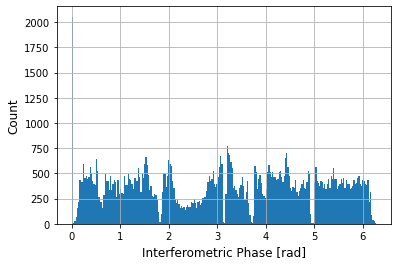

In [9]:
bins = plt.hist(phases, bins=240)
plt.grid()
plt.xlabel("Interferometric Phase [rad]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

The interferometric phase shows the trend to a uniform distribution. However, it seems like that their exist still interferometric phases
which have a higher occurrence than others.

## Basic Idea of Algorithm
Formally we represent the phases as a set of multi-sets. Therefor we discretize the range 0 to $2\pi$ into $n$ different values (basing on the histogram above it may be more useful to choice no equal steps). Formally we obtain a sequence $$a_i = \frac{2 \pi}{n}i$$
If it holds for a given phase $\varphi$ the following $$a_i \le \varphi < a_{i+1}$$ then we put $\varphi$ into the $i$-th multi-set. While every multiset is not empty we can calculate output phases with exactly one element of every multi set.

We can implement this by using a directed Graph where node $v_i$ represents $a_i$. Every child of node $v_i$ (and there children) is a measured interferometric phase. We can calculate the output phases iff a BFS counts exactly $n$ nodes. If the result is less than $n$ we are still missing phases to calculate the output phases.

<center>
    <img src="graph.png">

In the figure above a possible graph for the phases is shown.
</center>

<center>
<img src="graph_phasescan.png">

In the figure above a possible graph for the phases after a coloring is shown.
    </center>

## Implementation

In [10]:
import networkx as nx

In [11]:
G = nx.Graph()

In [12]:
n = 5
roots = []
for i in range(1, n):
    G.add_node(round(2 * np.pi / n * i, 2))
    roots.append(round(2 * np.pi / n * i, 2))

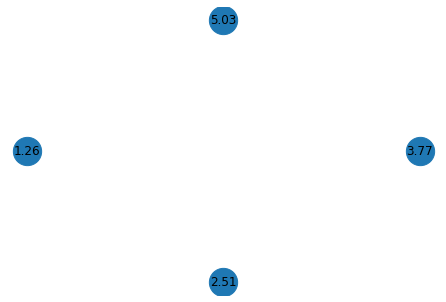

In [13]:
nx.draw_shell(G, with_labels=True, node_size=800)

In [14]:
for i in range(len(phases)):
    if i > 10:
        break
    k = int(n * phases[i] / (2 * np.pi))
    G.add_edge(i, list(G.nodes())[k])

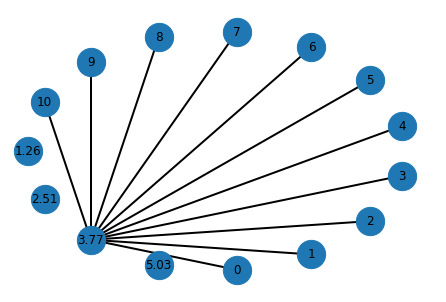

In [15]:
nx.draw_shell(G, with_labels=True, node_size=800, width=2)

The figure shows that the model works: every node is ordered to it's best-fit value. Every node $v_i$ of $a_i$ represents the root of a tree now. Hence we have a forest. Output phases can be calculated if the output degree of every node $v_i$ is at least 1.
If a node has an output degree > 1 we can color its node. If every tree has a colored node we can calculate with them the output phases and remove these nodes. At this moment the process repeats.

In [16]:
n = 100

def color_nodes(G, roots, root_node=0):
    colored_nodes = []
    for i in range(root_node, n):
        root = roots[i]
        neighbors = list(G[root])
        if neighbors != []:
            colored_node = neighbors[0]
            colored_nodes.append(colored_node)
            G.remove_node(colored_node)
        else:
            return i
    return colored_nodes

# Interial Seting of Parameters

In [17]:
data = np.array([decimation_data["DC1"][:85000], decimation_data["DC2"][:85000], decimation_data["DC3"][:85000]]).T
phase_scan = PhaseScan(data)
phase_scan.set_max()
phase_scan.set_min()
global_min = PhaseScan.min_intensities
global_max = PhaseScan.max_intensities
PhaseScan.swapp_channels = False
phase_scan.scale_data()
phase_scan.calulcate_output_phases()

In [18]:
phase_graph = nx.Graph()
roots = []
for i in range(n):
    phase_graph.add_node(2 * np.pi / n * i)
    roots.append(2 * np.pi / n * i)

In [19]:
output_phases = []
min_values = []
max_values = []
phases = []
signals = [[], [], []]
root_node = 1
t = 0
times = []
for dc_1, dc_2, dc_3 in zip(decimation_data["DC1"][:85000], decimation_data["DC2"][:85000], decimation_data["DC3"][:85000]):
    colored_nodes = None
    inversion = Inversion(signals=np.array([[dc_1, dc_2, dc_3]]))
    inversion.scale_data()
    phase = inversion.get_interferometric_phase()
    phases.append(phase)
    k = int(n * phase / (2 * np.pi))
    root = 2 * np.pi / n * k
    t += 1
    phase_graph.add_edge(t, root)
    colored_nodes = color_nodes(G=phase_graph, root_node=root_node, roots=roots)
    if isinstance(colored_nodes, list):
        for colored_node in colored_nodes:
            signals[0].append(decimation_data["DC1"][colored_node])
            signals[1].append(decimation_data["DC2"][colored_node])   
            signals[2].append(decimation_data["DC3"][colored_node])
        phase_scan = PhaseScan(np.array(signals).T)
        phase_scan.set_max()
        phase_scan.set_min()
        min_values.append(PhaseScan.min_intensities)
        max_values.append(PhaseScan.max_intensities)
        phase_scan.scale_data()
        phase_scan.calulcate_output_phases()
        output_phases.append(PhaseScan.output_phases)
        signals = [[], [], []]
        root_node = 0
        times.append(t)
    else:
        root_node = colored_nodes

In [20]:
times

[24882,
 25143,
 25144,
 25268,
 25282,
 25283,
 25304,
 25685,
 25686,
 25738,
 25803,
 25804,
 25980,
 26002,
 26098]

In [21]:
output_phases

[array([0.        , 1.82868826, 3.4906585 ]),
 array([0.        , 1.83753533, 3.4906585 ]),
 array([0.        , 1.8124573 , 3.71279132]),
 array([0.        , 1.83259571, 3.4906585 ]),
 array([0.        , 1.83753533, 3.4906585 ]),
 array([0.        , 1.7951958 , 3.71279132]),
 array([0.       , 1.7951958, 3.4906585]),
 array([0.        , 1.84799568, 3.4906585 ]),
 array([0.        , 1.83259571, 3.71279132]),
 array([0.        , 1.80641578, 3.4906585 ]),
 array([0.        , 1.80879577, 3.4906585 ]),
 array([0.        , 1.7951958 , 3.45575192]),
 array([0.        , 1.83753533, 3.4906585 ]),
 array([0.       , 1.7951958, 3.4906585]),
 array([0.        , 1.82212374, 3.4906585 ])]

In [22]:
output_phases = np.array(output_phases) / np.pi * 180
min_values = np.array(min_values) * 1e3
max_values = np.array(max_values) * 1e3

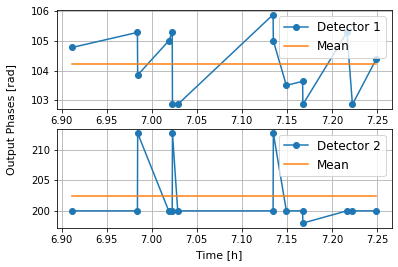

In [23]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(np.array(times) / 3600, output_phases.T[1], "o-", label="Detector 1")
ax1.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(output_phases.T[1]), label="Mean")
ax1.grid()
ax1.legend(fontsize=12)

ax2.plot(np.array(times) / 3600, output_phases.T[2], "o-", label="Detector 2")
ax2.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(output_phases.T[2]), label="Mean")
ax2.grid()
ax2.legend(fontsize=12)

fig.text(0.5, 0.02, "Time [h]", ha='center', fontsize=11)
fig.text(0.01, 0.5, "Output Phases [rad]", va='center', rotation='vertical', fontsize=11)
plt.show()

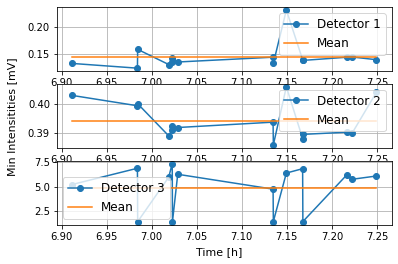

In [24]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(np.array(times) / 3600, min_values.T[0], "o-", label="Detector 1")
ax1.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(min_values.T[0]), label="Mean")
ax1.grid()
ax1.legend(fontsize=12)

ax2.plot(np.array(times) / 3600, min_values.T[1], "o-", label="Detector 2")
ax2.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(min_values.T[1]), label="Mean")
ax2.grid()
ax2.legend(fontsize=12)

ax3.plot(np.array(times) / 3600, min_values.T[2], "o-", label="Detector 3")
ax3.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(min_values.T[2]), label="Mean")
ax3.grid()
ax3.legend(fontsize=12)

fig.text(0.5, 0.02, "Time [h]", ha='center', fontsize=11)
fig.text(0.01, 0.5, "Min Intensitities [mV]", va='center', rotation='vertical', fontsize=11)

plt.show()

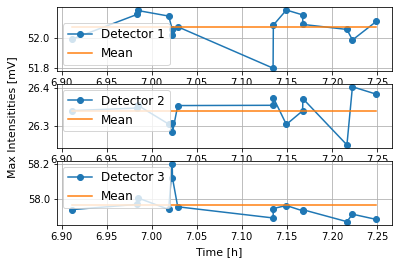

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(np.array(times) / 3600, max_values.T[0], "o-", label="Detector 1")
ax1.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(max_values.T[0]), label="Mean")
ax1.grid()
ax1.legend(fontsize=12)

ax2.plot(np.array(times) / 3600, max_values.T[1], "o-", label="Detector 2")
ax2.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(max_values.T[1]), label="Mean")
ax2.grid()
ax2.legend(fontsize=12)

ax3.plot(np.array(times) / 3600, max_values.T[2], "o-", label="Detector 3")
ax3.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(max_values.T[2]), label="Mean")
ax3.grid()
ax3.legend(fontsize=12)

fig.text(0.5, 0.02, "Time [h]", ha='center', fontsize=11)
fig.text(0.01, 0.5, "Max Intensitities [mV]", va='center', rotation='vertical', fontsize=11)

plt.show()

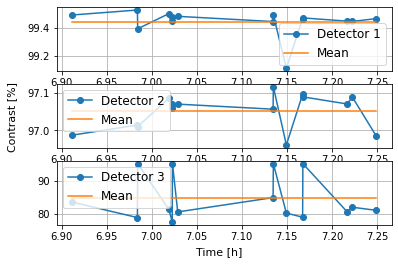

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

contrasts = (max_values - min_values) / (max_values + min_values) * 100

ax1.plot(np.array(times) / 3600, contrasts.T[0], "o-", label="Detector 1")
ax1.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(contrasts.T[0]), label="Mean")
ax1.grid()
ax1.legend(fontsize=12)

ax2.plot(np.array(times) / 3600, contrasts.T[1], "o-", label="Detector 2")
ax2.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(contrasts.T[1]), label="Mean")
ax2.grid()
ax2.legend(fontsize=12)

ax3.plot(np.array(times) / 3600, contrasts.T[2], "o-", label="Detector 3")
ax3.plot(np.array(times) / 3600, np.ones(len(times)) * np.mean(contrasts.T[2]), label="Mean")
ax3.grid()
ax3.legend(fontsize=12)

fig.text(0.5, 0.02, "Time [h]", ha='center', fontsize=11)
fig.text(0.01, 0.5, "Contrast [%]", va='center', rotation='vertical', fontsize=11)

plt.show()

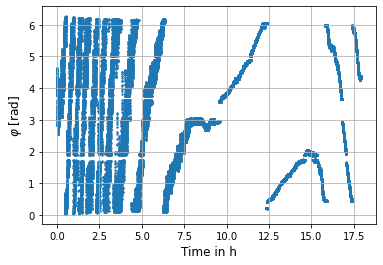

In [27]:
plt.scatter(np.arange(len(phases)) / 3600, phases, s=2)
plt.grid()
plt.xlabel("Time in h", fontsize=12)
plt.ylabel(r"$\varphi$ [rad]", fontsize=12)
plt.show()